In [1]:
import functions

from scipy.interpolate import interp1d
import glob
from matplotlib import pyplot as plt
from matplotlib import colormaps
import folium

parse gpx files into dataframe

In [2]:
files = glob.glob('*.gpx')

dataframes = []
for file in files:
    dataframe , acttype = functions.gpx2df(file)
    dataframes.append(dataframe)

stats

In [3]:
stats = functions.getstats(dataframes,files,acttype)
stats

find distance offset of activities (using the elevation profile)

In [4]:
Δl = functions.find_dist_off(dataframes)

plots

[]

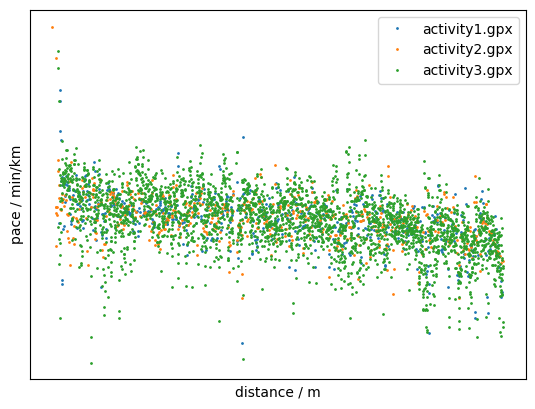

In [5]:
if acttype == 'running':
    _, plot = plt.subplots()
    for ind, df in enumerate(dataframes):
        plot.plot(df['distance / m'] + Δl[ind], df['pace / min/km'], '.', label = files[ind], markersize=2)
    plot.set(ylabel="pace / min/km")
    plot.invert_yaxis()
else:
    for ind, df in enumerate(dataframes):
        plt.plot(df['distance / m'] + Δl[ind], df['speed / km/h'], label = files[ind])
    plt.ylabel('speed / km/h')
plt.xlabel('distance / m')
plt.legend()

[]

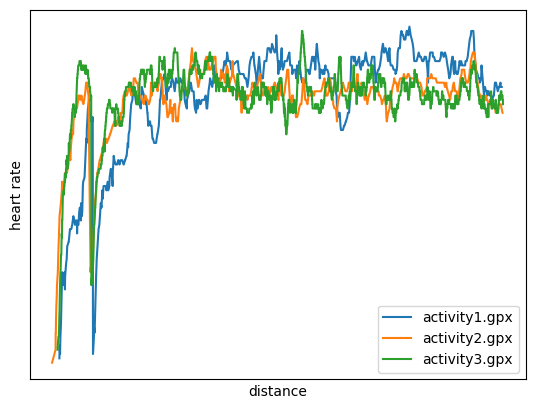

In [6]:
for ind, df in enumerate(dataframes):
    plt.plot(df['distance / m'] + Δl[ind], df['heart rate / bpm'], label = files[ind])
plt.xlabel('distance')
plt.ylabel('heart rate')
plt.legend()

[]

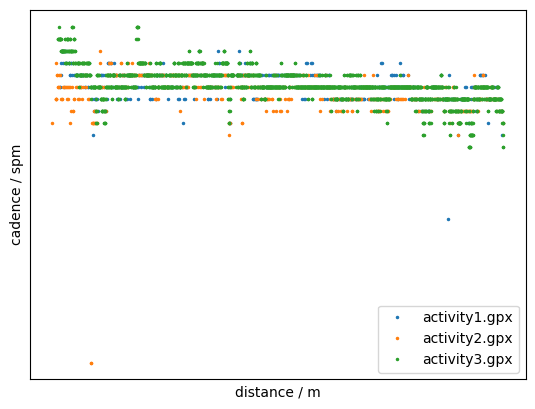

In [7]:
if acttype == 'running':
    for ind, df in enumerate(dataframes):
        plt.plot(df['distance / m'] + Δl[ind], df['cadence / spm'], '.', label = files[ind], markersize=3)
    plt.xlabel('distance / m')
    plt.ylabel('cadence / spm')
    plt.legend()

In [8]:
# plt.axvline(0, linestyle='--')
# if acttype == 'running':
#     plt.plot(df_plot['slope / %'], df_plot['pace / min/km'], '.')
#     plt.xlabel('slope / %')
#     plt.ylabel('pace / min/km')
# else:
#     plt.plot(- df_plot['slope / %'], df_plot['speed / km/h'], '.')
#     plt.xlabel('downhill slope / %')
#     plt.ylabel('speed / km/h')

[]

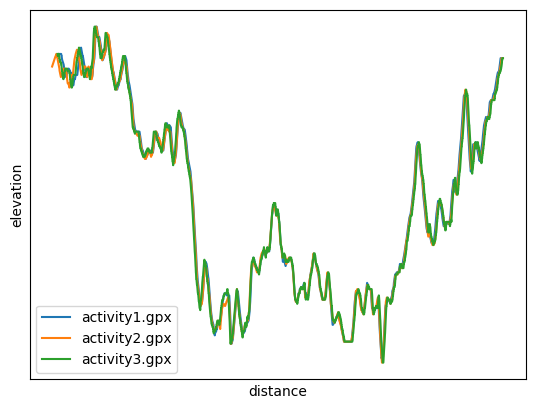

In [9]:
for ind, df in enumerate(dataframes):
    plt.plot(df['distance / m'] + Δl[ind], df['elevation / m'], label = files[ind])
plt.xlabel('distance')
plt.ylabel('elevation')
plt.legend()

In [12]:
route_map = folium.Map(
    location=[dataframes[0]['latitude / °'].mean(), dataframes[0]['longitude / °'].mean()],
    zoom_start=14,
    tiles='CartoDBPositron',
    # tiles='OpenStreetMap',
)

if len(dataframes) == 1:
    # speed color-coded in map
    cmap = colormaps['Spectral']
    if acttype == 'running':
        inter = interp1d([5,7.5],[0,1],fill_value="extrapolate")
    else:
        inter = interp1d([dataframes[0]['speed / km/h'].min(),dataframes[0]['speed / km/h'].max()],[1,0])
    # inter = interp1d([df['elevation / m'].min(),df['elevation / m'].max()],[1,0])

    for _, row in dataframes[0].dropna().iterrows():
        if acttype == 'running':
            rgb = cmap(inter(row['pace / min/km']))
        else:
            rgb = cmap(inter(row['speed / km/h']))
        # rgb = cmap(inter(row['elevation / m']))
        rgb = tuple([round(255*x) for x in rgb[:-1]])
        rgb = '#%02x%02x%02x' % rgb
        folium.CircleMarker(
            location = [row['latitude / °'], row['longitude / °']],
            color    = rgb,
            radius   = 1,
        ).add_to(route_map)
else:
    # different colors for individual activities
    cmap = colormaps['tab10']
    for ind, df in enumerate(dataframes):
        coordinates = [tuple(x) for x in df[['latitude / °', 'longitude / °']].to_numpy()]
        rgb = cmap(ind/10)
        rgb = tuple([round(255*x) for x in rgb[:-1]])
        rgb = '#%02x%02x%02x' % rgb
        folium.PolyLine(coordinates, weight=3, color=rgb).add_to(route_map)

route_map